##Imports

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Input
from keras.layers import Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import numpy as np
import pickle

Using TensorFlow backend.


## Load, split and preprocess the dataset

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/Colab\ Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [0]:
X_train, y_train, X_train_skel_features = None, None, None
with open("data/train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("data/test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]

In [0]:
num_classes = 10
img_rows, img_cols = 28, 28
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
X_train_skel_features = np.load('data_train.npy') 
X_test_skel_features = np.load('data_test.npy') 

input_dim_skelet = (X_train_skel_features.shape[1],)

## Define F1 score

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Define combined CNN with auxillary features gained from gradient boosting

In [8]:
input_shape_cnn = (28, 28, 1)
model_cnn_input = Input(input_shape_cnn) 
cnn_layer = Conv2D(32, (3, 3), activation='relu', 
input_shape=input_shape_cnn)(model_cnn_input) 

cnn_layer = Conv2D(64, (3, 3))(cnn_layer) 
cnn_layer = BatchNormalization()(cnn_layer) 
cnn_layer = Activation('relu')(cnn_layer) 
cnn_layer = Dropout(0.3)(cnn_layer) 
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)

cnn_layer = Conv2D(128, (3, 3))(cnn_layer) 
cnn_layer = BatchNormalization()(cnn_layer) 
cnn_layer = Activation('relu')(cnn_layer) 
cnn_layer = Dropout(0.3)(cnn_layer) 
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)                        
cnn_layer = Flatten()(cnn_layer) 

input_dim_skelet = (160, )
features_input = Input(input_dim_skelet) 
features_layer1 = Dense(32, input_dim=input_dim_skelet)(features_input) 

merged = Concatenate()([cnn_layer, features_layer1]) 
layer1 = Dropout(0.5)(merged) 
output_layer = Dense(10, activation='softmax')(layer1) 

model = Model(inputs=[model_cnn_input, features_input], outputs=output_layer) 
model.compile(loss="categorical_crossentropy", 
optimizer="adam", 
metrics=['accuracy', f1]) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

##Training process

In [9]:
early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best.model', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.7, patience=3, verbose=1)

history = model.fit([x_train, X_train_skel_features], y_train,
          batch_size=512,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau],
          verbose=1,
          validation_data=([x_test, X_test_skel_features], y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 13s 224us/step - loss: 3.5292 - acc: 0.7203 - f1: 0.7205 - val_loss: 0.1495 - val_acc: 0.9589 - val_f1: 0.9591

Epoch 00001: val_acc improved from -inf to 0.95890, saving model to best.model
Epoch 2/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1888 - acc: 0.9574 - f1: 0.9577 - val_loss: 0.0668 - val_acc: 0.9802 - val_f1: 0.9807

Epoch 00002: val_acc improved from 0.95890 to 0.98020, saving model to best.model
Epoch 3/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.1388 - acc: 0.9663 - f1: 0.9666 - val_loss: 0.0716 - val_acc: 0.9793 - val_f1: 0.9794

Epoch 00003: val_acc did not improve from 0.98020
Epoch 4/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.1130 - acc: 0.9712 - f1: 0.9715 - val_loss: 0.0530 - val_acc: 0.9841 - val_f1: 0.9842

Epoch 00004: val_acc improved from 0.98020 to 0.98410, 

## Error Analysis

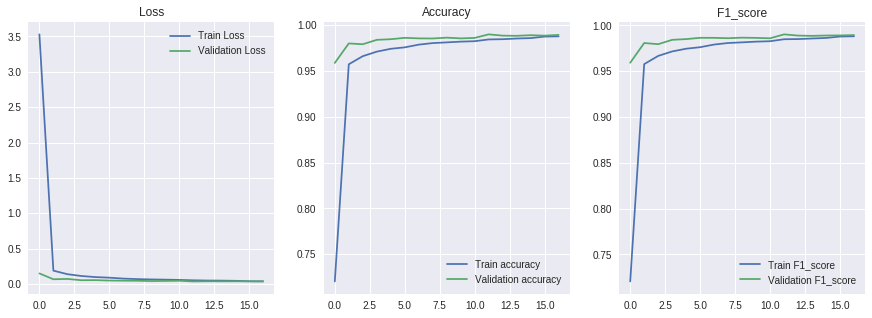

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["acc"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax[2].set_title('F1_score')
ax[2].plot(history.epoch, history.history["f1"], label="Train F1_score")
ax[2].plot(history.epoch, history.history["val_f1"], label="Validation F1_score")
ax[0].legend()
ax[1].legend()
ax[2].legend()

##Results

In [13]:
model = load_model('best.model', custom_objects={'f1': f1})
score = model.evaluate([x_test, X_test_skel_features], y_test, verbose=0)
print(f'Test loss: {score[0]: 0.5f}')
print(f'Test accuracy:{score[1]: 0.5f}')
print(f'Test f1_score:{score[2]: 0.5f}')

Test loss:  0.03594
Test accuracy: 0.99010
Test f1_score: 0.99011
